## TABLE OF CONTENTS:
* [Extracting Data + Pre-Processing](#first-bullet)
    * [Reading Images](#section_1_1)
    * [Cleaning & Pooling Data](#section_1_2)
    * [Splitting Data](#section_1_3)
* [Generating Deep Learning Models + Training On Data](#second-bullet)
    * [Initialize Autoencoder & Classifier](#section_2_1)
    * [Training Model & Classifying Encoded Images](#section_2_2)
* [Plot Training Metrics + Downstream Classification Results](#third-bullet)
    * [Plotting Autoencoder Train/Val Loss & Classifier Loss/Acc](#section_3_1)
    * [Plotting Confusion Matrices](#section_3_2)
* [Visualizing Decoded Images + Compressed Latent Space](#fourth-bullet)
    * [Plotting Decoded Images For Train/Test](#section_4_1)
    * [Plotting Train/Test Latent [TSNE & Isomap]](#section_4_2)
* [Finding Similar Images Based On Input](#fifth-bullet)

In [1]:
# handle imports
import os
os. chdir('/Users/ankushgupta/Documents/amazon_case_study/amazon_code')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Flatten, Dense, Reshape, Conv2DTranspose, InputLayer, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential
import os
import cv2
import io
import random as rd
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
# from tqdm.keras import TqdmCallback
import sys
from functions_computer_vision import *
from skimage import io 
%matplotlib inline

<h1><center> Extracting Data + Pre-Processing <a class="anchor" id="first-bullet"></a> </center></h1>

## Reading Images <a class="anchor" id="section_1_1"></a> 

In [2]:
# read the data in 
data_directory = '/Users/ankushgupta/Documents/amazon_case_study/data'
image_data_holder = {}
for directory in os.listdir(data_directory):
    sub_directory = os.path.join(data_directory, directory)
    if sub_directory.split('/')[-1].isalpha() == True:
        image_data_holder[sub_directory.split('/')[-1]] = {}
        path_to_jpgs = [os.path.join(sub_directory, _) for _ in os.listdir(sub_directory) if _.endswith(r".jpg")]
        for path in path_to_jpgs:
            image = io.imread(path)
            # try BGR2GRAY and RGB2GRAY
            # grey_scale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[:, :, np.newaxis]
            image_data_holder[sub_directory.split('/')[-1]][path.split('/')[-1].split('.')[-2]] = image
    else:
        pass

## Cleaning & Pooling Data  <a class="anchor" id="section_1_2"></a> 

In [3]:
# intialize some information and structures
labels = list(image_data_holder.keys())
pooled_image_data = []
pooled_image_labels = []
# utilize the shape of the first image for the first folder as reference (for ease)
ref_image_dim = np.shape(image_data_holder[list(labels)[0]][list(image_data_holder[list(labels)[0]])[0]])
for global_key in labels:
    for local_key in list(image_data_holder[global_key].keys()):
        # normalize the image between 0 and 1 
        image_data_holder[global_key][local_key] = image_data_holder[global_key][local_key] / np.max(image_data_holder[global_key][local_key])
        # making sure that all of the images are the same size 
        dims_check = image_data_holder[global_key][local_key].shape
        if dims_check != ref_image_dim:
            print('Resized Image: [' + global_key + '][' + local_key + ']')
            image_data_holder[global_key][local_key] = cv2.resize(image_data_holder[global_key][local_key], ref_image_dim[:2], interpolation=cv2.INTER_LINEAR)
        # pool data together for downstream tasks 
        pooled_image_data.append(image_data_holder[global_key][local_key])
        pooled_image_labels.append(np.where(np.asarray(labels) == np.asarray(global_key))[0][0])

## Splitting Data <a class="anchor" id="section_1_3"></a> 

In [4]:
# split the data into training/validation/test and reshape to input into model
training_split = 0.6
validation_split = 0.2
test_split = 0.2
x_train, x_temp, y_train, y_temp = train_test_split(np.asarray(pooled_image_data), np.asarray(pooled_image_labels), test_size=1-training_split, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=1 / ((1-training_split) / test_split), random_state=42)

training_data = np.array(x_train.reshape(-1, x_train.shape[1], x_train.shape[2], x_train.shape[-1]))
validation_data = np.array(x_val.reshape(-1, x_val.shape[1], x_val.shape[2], x_val.shape[-1]))
test_data = np.array(x_test.reshape(-1, x_test.shape[1], x_test.shape[2], x_test.shape[-1]))

<h1><center> Generating Deep Learning Models + Training On Data <a class="anchor" id="second-bullet"></a> </center></h1>

## Initialize Autoencoder & Classifier <a class="anchor" id="section_2_1"></a>

In [5]:
# initialize the convolutional autoencoder for image compression ---------> 
latent_dim = 100
conv_autoencoder_lr = 0.00005 
conv_autoencoder_epochs= 100
conv_autoencoder_batch = 10
classifier_lr = 0.0005
classifier_epochs = 500

encoder_input = Input(shape= ref_image_dim, name='Input Layer')
encoder_1 = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(encoder_input)
encoder_2 = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(encoder_1)
encoder_3 = Flatten()(encoder_2)
encoder_4 = Dense(latent_dim)(encoder_3)
encoder = Model(encoder_input, encoder_4, name='encoder')
# encoder.summary()

decoder_input = Input(shape=(latent_dim,))
decoder_1 = Dense(units=7*7*32, activation=tf.nn.relu)(decoder_input)
decoder_2 = Reshape(target_shape=(7, 7, 32))(decoder_1)
decoder_3 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_2)
decoder_4 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_3)
decoder_5 = Conv2DTranspose(filters=ref_image_dim[-1], kernel_size=3, strides=1, padding='same')(decoder_4)
decoder = Model(decoder_input, decoder_5, name='decoder')
# decoder.summary()

encoded = encoder(encoder_input)
decoded = decoder(encoded)
convolutional_autoencoder = Model(inputs=encoder_input, outputs=decoded, name='autoencoder')
convolutional_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=conv_autoencoder_lr), loss='mse')
# convolutional_autoencoder.summary()

# downstream classifier for gauging how well the encoded representation of original input can classify for the different labels
classifier_input = Input(shape=(latent_dim,))
classifier_1 = Dense(np.round(latent_dim/2), activation='relu')(classifier_input)
classifier_2 = Dense(np.round(latent_dim/4), activation='relu')(classifier_1)
classifier_3 = Dense(6, activation='softmax')(classifier_2)
downstream_classifier = Model(classifier_input, classifier_3)
downstream_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=classifier_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                             metrics=['accuracy'])
# downstream_classifier.summary()

2022-03-09 17:19:04.446901: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training Model & Classifying Encoded Images <a class="anchor" id="section_2_2"></a>

In [6]:
# run the data through the model
reconstruction_metrics = convolutional_autoencoder.fit(training_data, training_data, epochs=conv_autoencoder_epochs, 
                                                       batch_size=conv_autoencoder_batch, verbose=1, shuffle=True, validation_data=(validation_data, validation_data))
encoded_training_set = encoder.predict(training_data)
encoded_test_set = encoder.predict(test_data)
classification_metrics = downstream_classifier.fit(encoded_training_set, y_train, epochs=classifier_epochs, verbose=1, shuffle=True)

Epoch 1/100
1800/1800 [==============================] - 19s 10ms/step - loss: 0.0250 - val_loss: 0.0116
Epoch 2/100
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0093 - val_loss: 0.0081
Epoch 3/100
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 4/100
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 5/100
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 6/100
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 7/100
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 8/100
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 9/100
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 10/100
1800/1800 [==============================]

1800/1800 [==============================] - 20s 11ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 79/100
1800/1800 [==============================] - 20s 11ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 80/100
1800/1800 [==============================] - 19s 10ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 81/100
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 82/100
1800/1800 [==============================] - 19s 11ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 83/100
1800/1800 [==============================] - 19s 11ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 84/100
1800/1800 [==============================] - 19s 11ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 85/100
1800/1800 [==============================] - 19s 11ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 86/100
1800/1800 [==============================] - 19s 11ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 87/100
1800/1800 [==============================] - 2

563/563 [==============================] - 0s 734us/step - loss: 0.0958 - accuracy: 0.9690
Epoch 57/500
563/563 [==============================] - 0s 731us/step - loss: 0.0961 - accuracy: 0.9700
Epoch 58/500
563/563 [==============================] - 0s 734us/step - loss: 0.0943 - accuracy: 0.9696
Epoch 59/500
563/563 [==============================] - 0s 731us/step - loss: 0.0919 - accuracy: 0.9706
Epoch 60/500
563/563 [==============================] - 0s 735us/step - loss: 0.0917 - accuracy: 0.9707
Epoch 61/500
563/563 [==============================] - 0s 732us/step - loss: 0.0893 - accuracy: 0.9710
Epoch 62/500
563/563 [==============================] - 0s 733us/step - loss: 0.0918 - accuracy: 0.9697
Epoch 63/500
563/563 [==============================] - 0s 736us/step - loss: 0.0882 - accuracy: 0.9720
Epoch 64/500
563/563 [==============================] - 0s 731us/step - loss: 0.0867 - accuracy: 0.9721
Epoch 65/500
563/563 [==============================] - 0s 735us/step - loss:

563/563 [==============================] - 0s 740us/step - loss: 0.0370 - accuracy: 0.9889
Epoch 135/500
563/563 [==============================] - 0s 745us/step - loss: 0.0367 - accuracy: 0.9892
Epoch 136/500
563/563 [==============================] - 0s 732us/step - loss: 0.0382 - accuracy: 0.9887
Epoch 137/500
563/563 [==============================] - 0s 734us/step - loss: 0.0370 - accuracy: 0.9898
Epoch 138/500
563/563 [==============================] - 0s 734us/step - loss: 0.0356 - accuracy: 0.9892
Epoch 139/500
563/563 [==============================] - 0s 738us/step - loss: 0.0336 - accuracy: 0.9902
Epoch 140/500
563/563 [==============================] - 0s 739us/step - loss: 0.0346 - accuracy: 0.9903
Epoch 141/500
563/563 [==============================] - 0s 745us/step - loss: 0.0363 - accuracy: 0.9893
Epoch 142/500
563/563 [==============================] - 0s 731us/step - loss: 0.0347 - accuracy: 0.9894
Epoch 143/500
563/563 [==============================] - 0s 732us/ste

563/563 [==============================] - 0s 751us/step - loss: 0.0169 - accuracy: 0.9952
Epoch 213/500
563/563 [==============================] - 0s 745us/step - loss: 0.0155 - accuracy: 0.9955
Epoch 214/500
563/563 [==============================] - 0s 741us/step - loss: 0.0172 - accuracy: 0.9947
Epoch 215/500
563/563 [==============================] - 0s 735us/step - loss: 0.0195 - accuracy: 0.9937
Epoch 216/500
563/563 [==============================] - 0s 745us/step - loss: 0.0160 - accuracy: 0.9958
Epoch 217/500
563/563 [==============================] - 0s 739us/step - loss: 0.0147 - accuracy: 0.9959
Epoch 218/500
563/563 [==============================] - 0s 745us/step - loss: 0.0216 - accuracy: 0.9933
Epoch 219/500
563/563 [==============================] - 0s 744us/step - loss: 0.0205 - accuracy: 0.9937
Epoch 220/500
563/563 [==============================] - 0s 745us/step - loss: 0.0161 - accuracy: 0.9954
Epoch 221/500
563/563 [==============================] - 0s 773us/ste

563/563 [==============================] - 0s 734us/step - loss: 0.0070 - accuracy: 0.9983
Epoch 291/500
563/563 [==============================] - 0s 734us/step - loss: 0.0045 - accuracy: 0.9992
Epoch 292/500
563/563 [==============================] - 0s 730us/step - loss: 0.0067 - accuracy: 0.9984
Epoch 293/500
563/563 [==============================] - 0s 763us/step - loss: 0.0136 - accuracy: 0.9959
Epoch 294/500
563/563 [==============================] - 0s 733us/step - loss: 0.0112 - accuracy: 0.9962
Epoch 295/500
563/563 [==============================] - 0s 732us/step - loss: 0.0077 - accuracy: 0.9983
Epoch 296/500
563/563 [==============================] - 0s 734us/step - loss: 0.0107 - accuracy: 0.9967
Epoch 297/500
563/563 [==============================] - 0s 730us/step - loss: 0.0077 - accuracy: 0.9981
Epoch 298/500
563/563 [==============================] - 0s 734us/step - loss: 0.0089 - accuracy: 0.9973
Epoch 299/500
563/563 [==============================] - 0s 735us/ste

563/563 [==============================] - 0s 737us/step - loss: 0.0028 - accuracy: 0.9997
Epoch 369/500
563/563 [==============================] - 0s 736us/step - loss: 0.0024 - accuracy: 0.9997
Epoch 370/500
563/563 [==============================] - 0s 744us/step - loss: 0.0070 - accuracy: 0.9976
Epoch 371/500
563/563 [==============================] - 0s 735us/step - loss: 0.0172 - accuracy: 0.9944
Epoch 372/500
563/563 [==============================] - 0s 739us/step - loss: 0.0043 - accuracy: 0.9989
Epoch 373/500
563/563 [==============================] - 0s 744us/step - loss: 0.0021 - accuracy: 0.9998
Epoch 374/500
563/563 [==============================] - 0s 734us/step - loss: 0.0145 - accuracy: 0.9954
Epoch 375/500
563/563 [==============================] - 0s 739us/step - loss: 0.0085 - accuracy: 0.9976
Epoch 376/500
563/563 [==============================] - 0s 737us/step - loss: 0.0033 - accuracy: 0.9995
Epoch 377/500
563/563 [==============================] - 0s 742us/ste

563/563 [==============================] - 0s 740us/step - loss: 0.0013 - accuracy: 0.9999
Epoch 447/500
563/563 [==============================] - 0s 742us/step - loss: 0.0259 - accuracy: 0.9921
Epoch 448/500
563/563 [==============================] - 0s 739us/step - loss: 0.0086 - accuracy: 0.9974
Epoch 449/500
563/563 [==============================] - 0s 739us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 450/500
563/563 [==============================] - 0s 737us/step - loss: 9.0932e-04 - accuracy: 1.0000
Epoch 451/500
563/563 [==============================] - 0s 762us/step - loss: 9.7201e-04 - accuracy: 1.0000
Epoch 452/500
563/563 [==============================] - 0s 745us/step - loss: 0.0159 - accuracy: 0.9954
Epoch 453/500
563/563 [==============================] - 0s 745us/step - loss: 0.0103 - accuracy: 0.9972
Epoch 454/500
563/563 [==============================] - 0s 736us/step - loss: 0.0025 - accuracy: 0.9996
Epoch 455/500
563/563 [==============================] - 0s 7

<h1><center> Plot Training Metrics + Downstream Classification Results <a class="anchor" id="third-bullet"></a> </center></h1>

## Plotting Autoencoder Train/Val Loss & Classifier Loss/Acc <a class="anchor" id="section_3_1"></a>

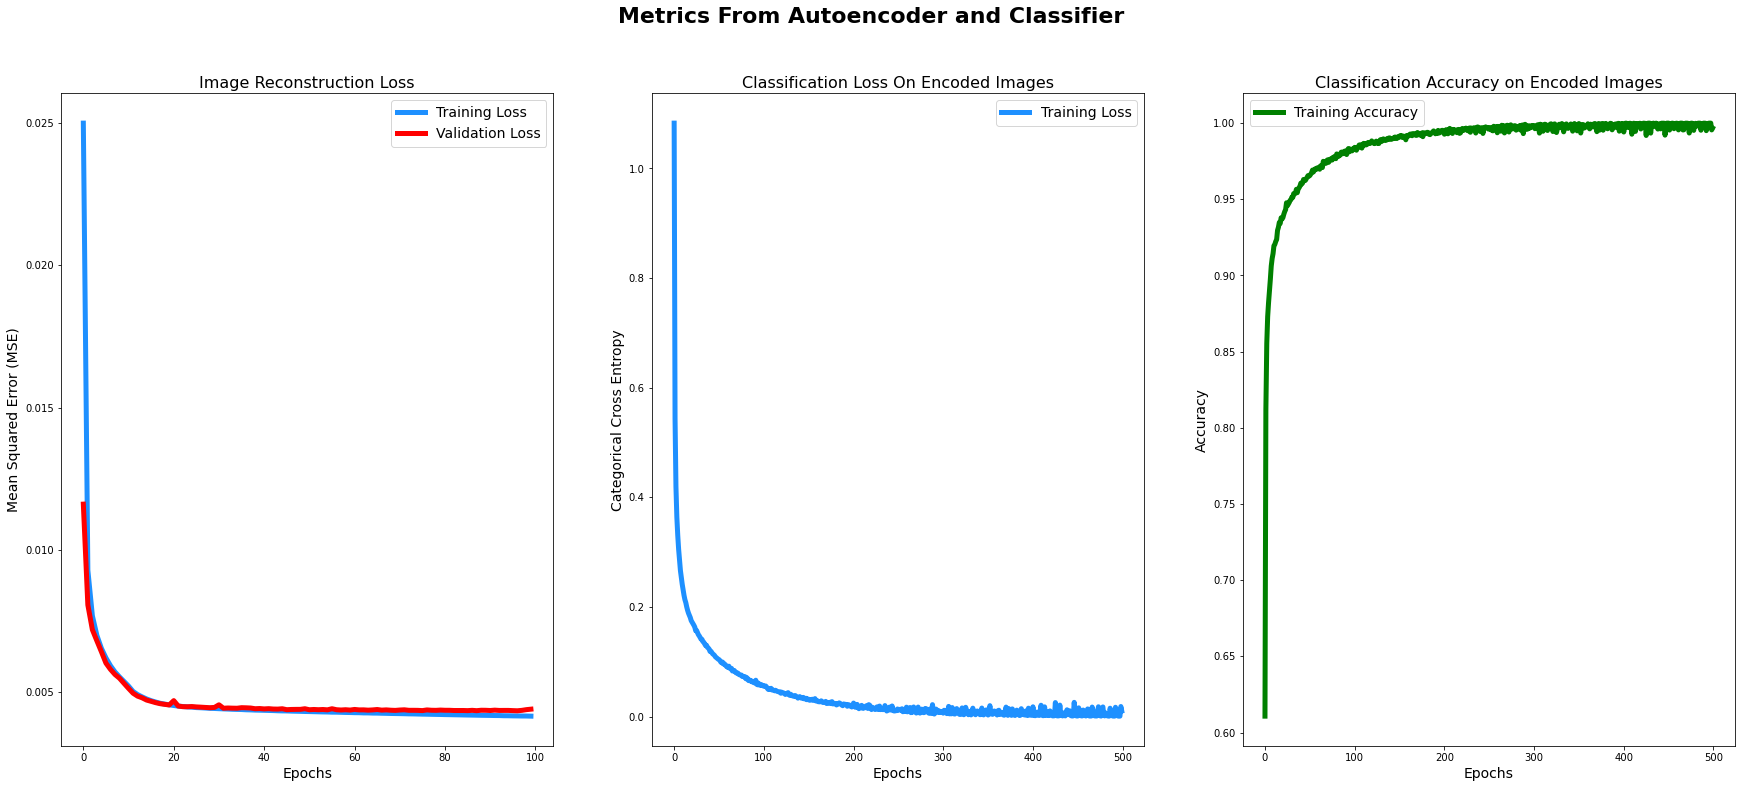

In [7]:
# plot the training and validation loss metrics 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 12))

# plot the image reconstruction loss 
ax1.plot(range(len(reconstruction_metrics.history['loss'])), reconstruction_metrics.history['loss'], label='Training Loss', linewidth=5, color='dodgerblue')
ax1.plot(range(len(reconstruction_metrics.history['val_loss'])), reconstruction_metrics.history['val_loss'], label='Validation Loss', linewidth=5, color='red')
ax1.legend(fontsize=14), ax1.set_xlabel('Epochs', fontsize=14), ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
ax1.set_title('Image Reconstruction Loss', fontsize=16)

# plot the classification metrics 
ax2.plot(range(len(classification_metrics.history['loss'])), classification_metrics.history['loss'], label='Training Loss', linewidth=5, color='dodgerblue')
ax3.plot(range(len(classification_metrics.history['accuracy'])), classification_metrics.history['accuracy'], label='Training Accuracy', linewidth=5, color='green')
ax2.legend(fontsize=14), ax2.set_xlabel('Epochs', fontsize=14), ax2.set_ylabel('Categorical Cross Entropy', fontsize=14)
ax3.legend(fontsize=14), ax3.set_xlabel('Epochs', fontsize=14), ax3.set_ylabel('Accuracy', fontsize=14)
ax2.set_title('Classification Loss On Encoded Images', fontsize=16)
ax3.set_title('Classification Accuracy on Encoded Images', fontsize=16)

plt.suptitle('Metrics From Autoencoder and Classifier', fontsize=22, fontweight='bold')
plt.show()

## Plotting Confusion Matrices <a class="anchor" id="section_3_2"></a>

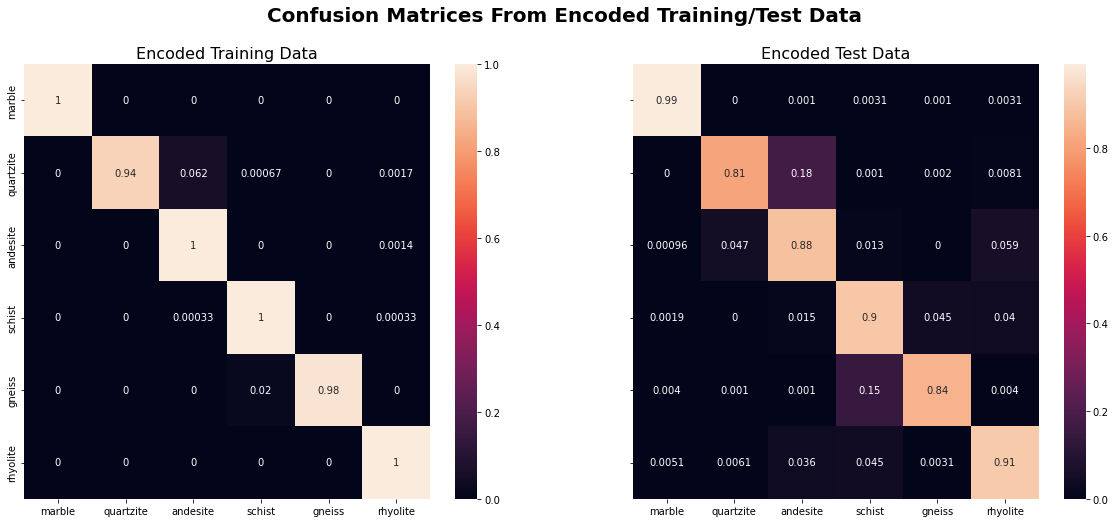

In [8]:
# plot confusion matrix of the classification results 

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

train_predictions = downstream_classifier.predict(encoded_training_set)
train_predicted_labels = [np.where(train_predictions[x] == np.max(train_predictions[x]))[0][0] for x in range(np.shape(train_predictions)[0])]
train_norm_matrix = confusion_matrix(y_train, train_predicted_labels, normalize='true')
sns.heatmap(train_norm_matrix, ax=axes[0], annot=True, yticklabels=labels, xticklabels=labels)
axes[0].set_title('Encoded Training Data', fontsize=16)

test_predictions = downstream_classifier.predict(encoded_test_set)
test_predicted_labels = [np.where(test_predictions[x] == np.max(test_predictions[x]))[0][0] for x in range(np.shape(test_predictions)[0])]
test_norm_matrix = confusion_matrix(y_test, test_predicted_labels, normalize='true')
sns.heatmap(test_norm_matrix, ax=axes[1], annot=True, yticklabels=labels, xticklabels=labels)
axes[1].set_title('Encoded Test Data', fontsize=16)

plt.suptitle('Confusion Matrices From Encoded Training/Test Data', fontweight='bold', fontsize=20)
plt.show()

<h1><center> Visualizing Decoded Images + Compressed Latent Space <a class="anchor" id="fourth-bullet"></a> </center></h1>

## Plotting Decoded Images For Train/Test <a class="anchor" id="section_4_1"></a>

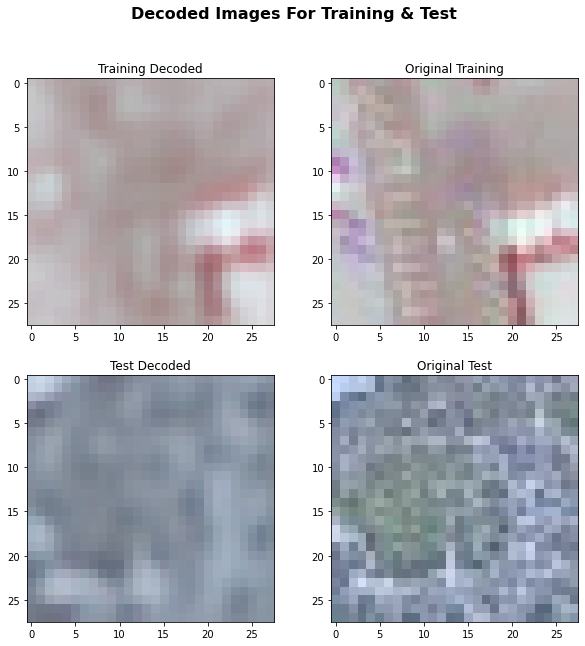

In [9]:
# utilize the encoder to generate latent representations on training set and test set 
test_decoded = convolutional_autoencoder.predict(test_data)
train_decoded = convolutional_autoencoder.predict(training_data)
random_image = np.random.randint(0, np.shape(test_decoded)[0]-1)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax1.imshow((train_decoded[random_image]* 255).astype(np.uint8))
ax2.imshow((training_data[random_image]* 255).astype(np.uint8))
ax3.imshow((test_decoded[random_image]* 255).astype(np.uint8))
ax4.imshow((test_data[random_image]* 255).astype(np.uint8))
ax1.set_title('Training Decoded'), ax2.set_title('Original Training'), ax3.set_title('Test Decoded'), ax4.set_title('Original Test')
plt.suptitle('Decoded Images For Training & Test', fontweight='bold', fontsize=16)
plt.show()

## Plotting Train/Test Latent [TSNE & Isomap] <a class="anchor" id="section_4_2"></a>

/Users/ankushgupta/opt/anaconda3/envs/computer_vision/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ankushgupta/opt/anaconda3/envs/computer_vision/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17998 samples in 0.001s...
[t-SNE] Computed neighbors for 17998 samples in 6.209s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17998
[t-SNE] Computed conditional probabilities for sample 2000 / 17998
[t-SNE] Computed conditional probabilities for sample 3000 / 17998
[t-SNE] Computed conditional probabilities for sample 4000 / 17998
[t-SNE] Computed conditional probabilities for sample 5000 / 17998
[t-SNE] Computed conditional probabilities for sample 6000 / 17998
[t-SNE] Computed conditional probabilities for sample 7000 / 17998
[t-SNE] Computed conditional probabilities for sample 8000 / 17998
[t-SNE] Computed conditional probabilities for sample 9000 / 17998
[t-SNE] Computed conditional probabilities for sample 10000 / 17998
[t-SNE] Computed conditional probabilities for sample 11000 / 17998
[t-SNE] Computed conditional probabilities for sample 12000 / 17998
[t-SNE] Computed conditional probabilities for sam

/Users/ankushgupta/opt/anaconda3/envs/computer_vision/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ankushgupta/opt/anaconda3/envs/computer_vision/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.001s...
[t-SNE] Computed neighbors for 6000 samples in 0.791s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.478228
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.905937
[t-SNE] KL divergence after 1000 iterations: 2.473233


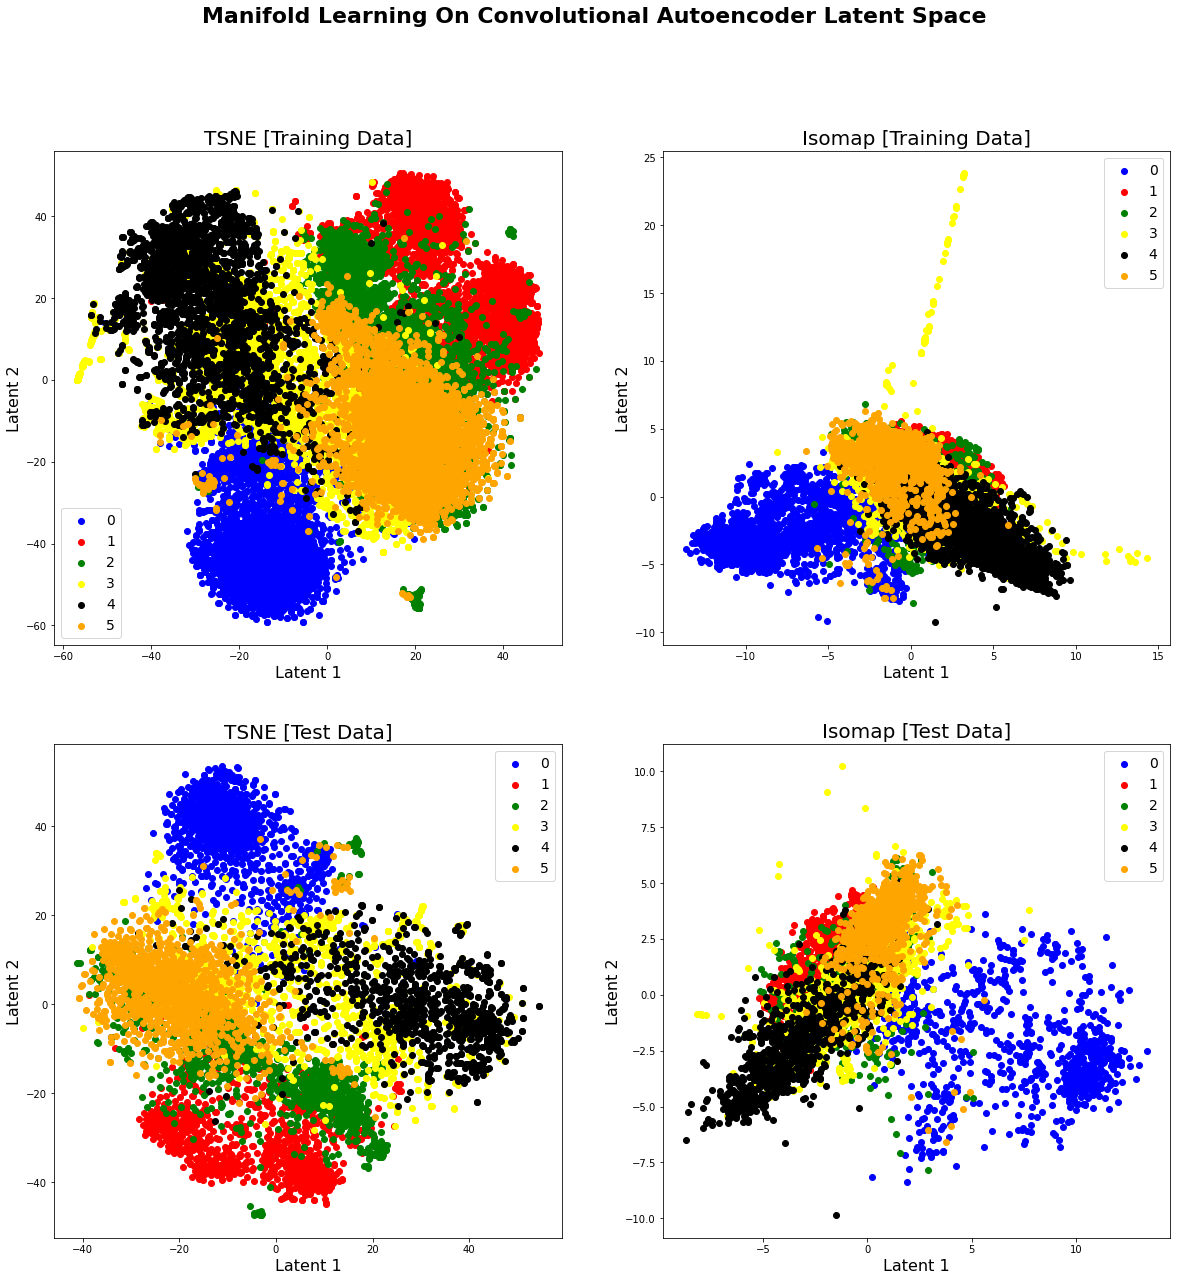

In [10]:
# plot the latent space 

if latent_dim == 2 or latent_dim == 3:
    if latent_dim == 3:
        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    elif latent_dim == 2:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    colors = ['blue', 'red', 'green', 'yellow', 'black', 'orange']
    for num in np.unique(y_train):
        train_indices = np.where(y_train == num)[0]
        test_indices = np.where(y_test == num)[0]
        if latent_dim == 3:
            ax1.scatter3D(encoded_training_set[train_indices, 0], encoded_training_set[train_indices, 1], encoded_training_set[train_indices, 2], alpha=0.5, color=colors[num])
            ax2.scatter3D(encoded_test_set[test_indices, 0], encoded_test_set[test_indices, 1], encoded_test_set[test_indices, 2], alpha=0.5, color=colors[num])
        elif latent_dim == 2:
            ax1.scatter(encoded_training_set[train_indices, 0], encoded_training_set[train_indices, 1], alpha=0.5, color=colors[num])
            ax2.scatter(encoded_test_set[test_indices, 0], encoded_test_set[test_indices, 1], alpha=0.5, color=colors[num])
    ax1.set_title('Training Data'), ax2.set_title('Test Data')
    if latent_dim >= 2:
        ax1.set_xlabel('Latent 1'), ax1.set_ylabel('Latent 2'), ax2.set_xlabel('Latent 1'), ax2.set_ylabel('Latent 2')
    elif latent_dim >= 3:
        ax1.set_zlabel('Latent 3'), ax2.set_zlabel('Latent 3')
    plt.suptitle(str(latent_dim) + 'D Latent Space', fontsize=16, fontweight='bold')
elif latent_dim > 3: 
    # using t-SNE and Isomap on high dimensional latent space for visualization
    # for training data 
    TSNE_model = TSNE(n_components=2, verbose=1, random_state=123)
    isomap_model = Isomap(n_components=2)
    tsne_training = TSNE_model.fit_transform(encoded_training_set)
    isomap_training = isomap_model.fit_transform(encoded_training_set)
    # for test data
    TSNE_model = TSNE(n_components=2, verbose=1, random_state=123)
    isomap_model = Isomap(n_components=2)
    tsne_test = TSNE_model.fit_transform(encoded_test_set)
    isomap_test = isomap_model.fit_transform(encoded_test_set)
    # plotting t-sne and isomap results for training and test datasets 
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
    colors = ['blue', 'red', 'green', 'yellow', 'black', 'orange']
    for x in np.unique(y_train):
        training_indices = np.where(y_train == x)[0]
        test_indices = np.where(y_test == x)[0]
        ax1.scatter(tsne_training[training_indices, 0], tsne_training[training_indices, 1], color=colors[x], label=str(x))
        ax2.scatter(isomap_training[training_indices, 0], isomap_training[training_indices, 1], color=colors[x], label=str(x))
        ax3.scatter(tsne_test[test_indices, 0], tsne_test[test_indices, 1], color=colors[x], label=str(x))
        ax4.scatter(isomap_test[test_indices, 0], isomap_test[test_indices, 1], color=colors[x], label=str(x))

    titles = ['TSNE [Training Data]', 'Isomap [Training Data]', 'TSNE [Test Data]', 'Isomap [Test Data]']
    axes = [ax1, ax2, ax3, ax4]
    for axis in range(len(axes)):
        axes[axis].set_xlabel('Latent 1', fontsize=16), axes[axis].set_ylabel('Latent 2', fontsize=16), axes[axis].legend(fontsize=14), axes[axis].set_title(titles[axis], fontsize=20)
    plt.suptitle('Manifold Learning On Convolutional Autoencoder Latent Space', fontsize=22, fontweight='bold')
plt.show()

<h1><center> Finding Similar Images Based On Input <a class="anchor" id="fifth-bullet"></a> </center></h1>

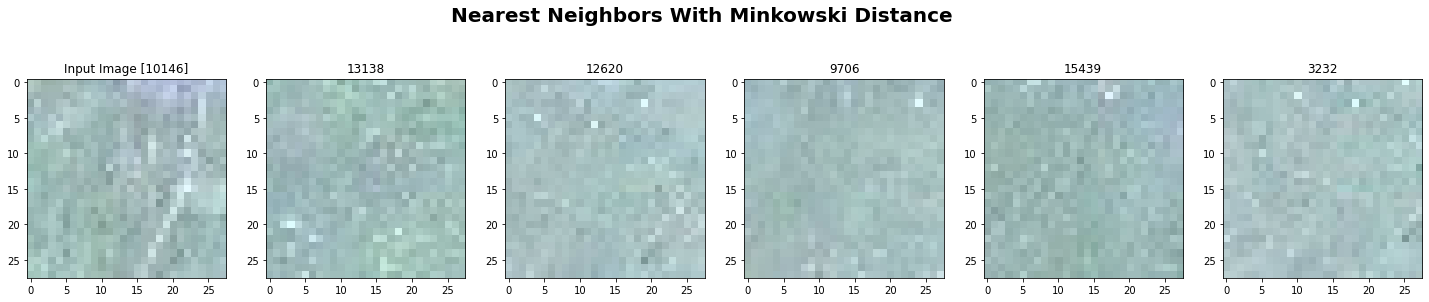

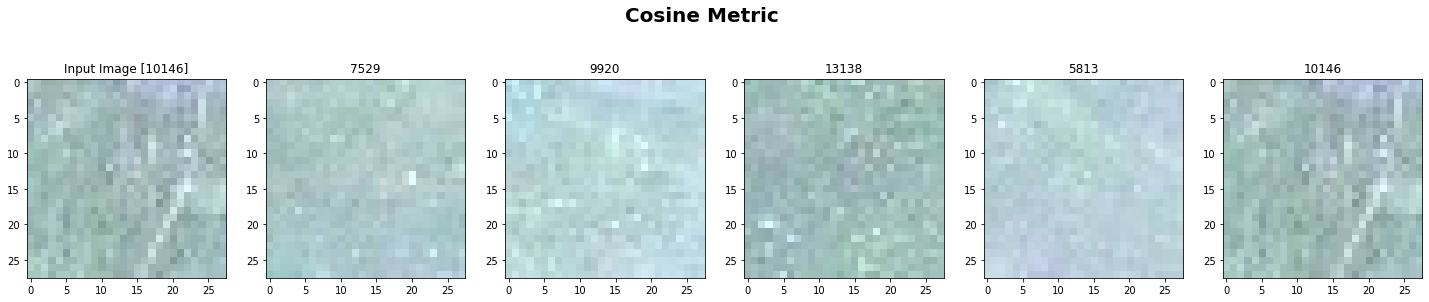

In [11]:
# Compute the cosine similarity between images 
image_input_index = np.random.randint(0, len(encoded_training_set))
top_similar_images = 5
fig, axes1 = plt.subplots(1, top_similar_images+1, figsize=(25, 5))
plt.suptitle('Nearest Neighbors With Minkowski Distance', fontweight='bold', fontsize=20)
fig2, axes2 = plt.subplots(1, top_similar_images+1, figsize=(25, 5))
plt.suptitle('Cosine Metric', fontweight='bold', fontsize=20)

# KNN 
X = np.array(encoded_training_set)
nbrs = NearestNeighbors(n_neighbors=top_similar_images+1).fit(X)
distances, indices = nbrs.kneighbors(X)
# cosine similarity
encoded_training_df = pd.DataFrame(data=encoded_training_set)
cosine_vals = cosine_similarity(encoded_training_df, dense_output=True)
cosine_indices = np.argpartition(cosine_vals[image_input_index, :], -1*top_similar_images-1)[-1*top_similar_images-1:]

for x in range(2):
    if x == 0:
        index_list = indices[image_input_index, :]
        axes = axes1 
    elif x == 1:
        cosine_indices = list(cosine_indices)
        cosine_indices.insert(0, image_input_index)
        cosine_indices.pop(cosine_indices[1:].index(image_input_index))
        index_list = cosine_indices
        axes = axes2
    for index in range(len(index_list)):
        axes[index].imshow(x_train[index_list[index]])
        if index == 0:
            axes[index].set_title('Input Image [' + str(index_list[index]) + ']')
        else:
            axes[index].set_title(str(index_list[index]))
plt.show()